# Case Study 4.1 - Movies

## Case Study Description: Building your own recommendation system for movies

# Setup

Run these cells to install all the packages 

In [6]:
!pip install surprise

    100% |████████████████████████████████| 3.3MB 500kB/s ta 0:00:011
    100% |████████████████████████████████| 31.2MB 54kB/s eta 0:00:011  4% |█▋                              | 1.5MB 24.6MB/s eta 0:00:02    24% |███████▊                        | 7.5MB 25.4MB/s eta 0:00:01    25% |████████▎                       | 8.0MB 11.8MB/s eta 0:00:02    57% |██████████████████▌             | 18.0MB 7.6MB/s eta 0:00:02    59% |███████████████████             | 18.6MB 7.4MB/s eta 0:00:02    65% |█████████████████████▏          | 20.6MB 6.8MB/s eta 0:00:02
  Running setup.py bdist_wheel for scikit-surprise ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise
  Found existing installation: scipy 0.19.1
    Uninstalling scipy-0.19.1:
      Successfully uninstalled scipy-0.19.1


Now, you must press **Kernel > Restart.** This allows the installation to take effect. Once you see the blue **Connected/Kernel ready** button in the top right, you are good to go.

# Import

In [2]:
import pandas as pd
import matplotlib
from surprise import Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold

# Data

Use the [`**Dataset.load_builtin**`](http://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_builtin) function to load the data.

In [3]:
# Your code here to load the data...
data=Dataset.load_builtin('ml-100k')

We also want to get a sense of what the data looks like. Please create a histogram of all the ratings we have in the dataset.

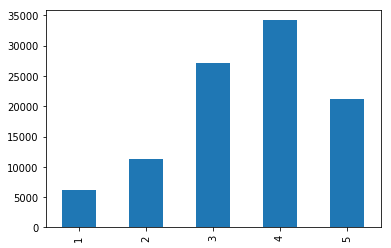

In [5]:
# Your code here to create a ratings histogram...
rf=data.ratings_file
col_names = ['user_id', 'item_id', 'rating', 'timestamp']
raw_data = pd.read_table(rf,names=col_names)
raw_data.head(5)
raw_data['rating'].value_counts().sort_index().plot.bar()

In [6]:
raw_data['rating'].value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

# Model 1: Random


##### We want to first get a baseline value for our model. That can be best done with random model as this algorithm is not personalized to the desires of any users - we just assign them movie ratings based on the initial distribution of the data.

We want to first get a baseline value for our model. That can be best done with random model as this algorithm is not personalized to the desires of any users - we just assign them movie ratings based on the initial distribution of the data.

In [7]:
# Create model using NormalPredictor() class
model=NormalPredictor()

In [8]:
# Train on data using cross-validation with k=5 folds, measuring the RMSE
model_random_results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
# See the cross_validate function that we have imported above
# http://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.validation.cross_validate

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5230  1.5143  1.5237  1.5265  1.5187  1.5212  0.0043  
Fit time          0.47    0.67    0.65    0.50    0.52    0.56    0.08    
Test time         1.06    0.83    0.97    0.65    0.65    0.83    0.17    


# Model 2: User-Based Collaborative Filtering

##### User-Based Collaborative Filtering model will use the user-user defined notion of similarity to implement collaborative filtering.

In [9]:
# Create model using KNNBasic() class
sim_options={'name':'cosine','user_based':True}
model_KNN_user_based=KNNBasic(sim_options=sim_options)

# See the sim_options parameter to determine the user/item similarity calculation of the model
# http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration

In [10]:
# Train using same cross validation code as above
model_KNN_user_based_results = cross_validate(model_KNN_user_based, data, measures=['RMSE'], cv=5, verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0071  1.0141  1.0189  1.0230  1.0232  1.0173  0.0061  
Fit time          4.99    5.04    5.78    5.71    5.31    5.37    0.33    
Test time         16.88   17.86   20.32   18.16   17.23   18.09   1.20    


# Model 3: Item-Based Collaborative Filtering

##### This model will use item-item defined notion of similarity to once again implement collaborative filtering.

In [11]:
# Create model using KNNBasic() class
# Make sure you change the sim_options parameter from above
sim_options={'name':'cosine','user_based':False}
model_KNN_item_based=KNNBasic(sim_options=sim_options)

In [12]:
# Train using same cross validation code as above
model_KNN_item_based_results = cross_validate(model_KNN_item_based, data, measures=['RMSE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0216  1.0271  1.0184  1.0218  1.0409  1.0259  0.0080  
Fit time          8.65    9.01    7.23    7.46    8.76    8.22    0.73    
Test time         18.57   18.50   17.97   18.36   20.77   18.83   0.99    


# Model 4: Matrix Factorization
##### Our final model for this case study will use the matrix factorization approach with the SVD algorithm to try to predict user’s movie ratings. Here, we try to determine some underlying mathematical structure in the user rating matrix, which can help us predict missing ratings in the future.

In [13]:
# Create model using SVD() class
model_SVD=SVD()

In [14]:
# Train using same cross validation code as above
model_SVD_results = cross_validate(model_SVD,data,measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9292  0.9328  0.9368  0.9418  0.9376  0.9356  0.0043  
Fit time          23.29   24.40   23.69   26.45   25.83   24.73   1.22    
Test time         0.90    0.84    1.30    1.33    1.25    1.12    0.21    


# Precision and Recall @ `k`

In [ ]:
Here precision and recall is computed

In [15]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = dict()
    for uid, _, true_r, est, _ in predictions:
        current = user_est_true.get(uid, list())
        current.append((est, true_r))
        user_est_true[uid] = current

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

Next, we compute the precision and recall at `k` = 5 and 10 for each of our 4 models. We use 5-fold cross validation again to average the results across the entire dataset.

Please note that this will take some time to compute.

In [17]:
# Use the function above to compute the 16 numerical values requested above
K=[5,10]
models=[model,model_KNN_user_based,model_KNN_item_based,model_SVD]

kf = KFold(n_splits=5)
for k in K:
    for modl in models:
        p=[]
        r=[]
        for train_set,test_set in kf.split(data):
            modl.fit(train_set)
            predictions=model.test(test_set,verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)
            
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
            
        print('>>> precision:', round(sum(p) / len(p), 3))
        print('>>> reccall  :', round(sum(r) / len(r), 3))
        


# See the test() function to get the predictions input to the function
# http://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.test

>>> precision: 0.587
>>> reccall  : 0.34
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
>>> precision: 0.583
>>> reccall  : 0.342
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
>>> precision: 0.586
>>> reccall  : 0.344
>>> precision: 0.589
>>> reccall  : 0.345
>>> precision: 0.583
>>> reccall  : 0.425
Computing the cosine similarity

#  Top-`n` Predictions

Finally, we can see what some of the actual movie ratings are for particular users, as outputs of our model.

In [18]:
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Then, we call this function on each of our models, first training on **all** the data we have available, then predicting on the remaining, missing data. We use `n`=5 here, but you can pick any reasonable value of `n` you would like.

This may take some time to compute, so be patient.

Hint: Use [`**Dataset.build_full_trainset**`](http://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.DatasetAutoFolds.build_full_trainset) to get the full trainset from the data. Then call [`**Trainset.build_anti_testset**`](http://surprise.readthedocs.io/en/stable/trainset.html#surprise.Trainset.build_anti_testset) to get the testset out. Finally, `fit` on the trainset, `test` on the testset, then pass that result to our `get_top_n` function.

In [19]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [20]:
# Use the function and hints above to give the top-n predictions for a given user, for a reasonable value of n
for model in models:
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Print the first one
    user = list(top_n.keys())[0]
    print(f'model: {model}, {user}: {top_n[user]}')

model: <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f5934a6cc88>, 196: [('16', 5), ('979', 5), ('526', 5), ('21', 5), ('264', 5)]
Computing the cosine similarity matrix...
Done computing similarity matrix.
model: <surprise.prediction_algorithms.knns.KNNBasic object at 0x7f593b7c7e10>, 196: [('1189', 5), ('1500', 5), ('814', 5), ('1536', 5), ('1293', 5)]
Computing the cosine similarity matrix...
Done computing similarity matrix.
model: <surprise.prediction_algorithms.knns.KNNBasic object at 0x7f5934a6cda0>, 196: [('1309', 4.5), ('1310', 4.5), ('1676', 4.25), ('1675', 4.25), ('1593', 4.090909090909091)]
model: <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f5934a6c978>, 196: [('114', 4.702587518165476), ('603', 4.4913732760844844), ('357', 4.423351836916481), ('64', 4.423188384608302), ('169', 4.421457082682124)]


<hr>

Great job! Now, make sure you check out the **Conclusion** section of the [instruction manual](https://courses.edx.org/asset-v1:MITxPRO+DSx+2T2018+type@asset+block@4.1_instruction_manual.html) to wrap up this case study properly.